In [1]:
pip install gym-anytrading

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade gym-anytrading

  Using cached gym_anytrading-2.0.0-py3-none-any.whl.metadata (292 bytes)
INFO: pip is looking at multiple versions of gym-anytrading to determine which version is compatible with other requirements. This could take a while.
Note: you may need to restart the kernel to use updated packages.


### Create an environment

In [1]:
import gym
import gym_anytrading

env = gym.make('forex-v0')


- This will create the default environment. You can change any parameters such as dataset, frame_bound, etc.

### Create an environment with custom parameters

In [2]:
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL

custom_env = gym.make(
    'forex-v0',
    df=FOREX_EURUSD_1H_ASK,
    window_size=10,
    frame_bound=(10, 300),
    unit_side='right'
)

# custom_env = gym.make(
#     'stocks-v0',
#     df=STOCKS_GOOGL,
#     window_size=10,
#     frame_bound=(10, 300)
# )

- It is to be noted that the first element of `frame_bound` should be greater than or equal to `window_size`.

### Print some information

In [3]:
print("env information:")
print("> shape:", env.unwrapped.shape)
print("> df.shape:", env.unwrapped.df.shape)
print("> prices.shape:", env.unwrapped.prices.shape)
print("> signal_features.shape:", env.unwrapped.signal_features.shape)
print("> max_possible_profit:", env.unwrapped.max_possible_profit())

print()
print("custom_env information:")
print("> shape:", custom_env.unwrapped.shape)
print("> df.shape:", custom_env.unwrapped.df.shape)
print("> prices.shape:", custom_env.unwrapped.prices.shape)
print("> signal_features.shape:", custom_env.unwrapped.signal_features.shape)
print("> max_possible_profit:", custom_env.unwrapped.max_possible_profit())

env information:
> shape: (24, 2)
> df.shape: (6225, 5)
> prices.shape: (6225,)
> signal_features.shape: (6225, 2)
> max_possible_profit: 4.054407219413578

custom_env information:
> shape: (10, 2)
> df.shape: (6225, 5)
> prices.shape: (300,)
> signal_features.shape: (300, 2)
> max_possible_profit: 1.1228998536878634


- Here `max_possible_profit` signifies that if the market didn't have trade fees, you could have earned **4.054414887146572** (or **1.1229001800089833**) units of currency by starting with **1.0**. In other words, your money is almost *quadrupled*.

### Plot the environment

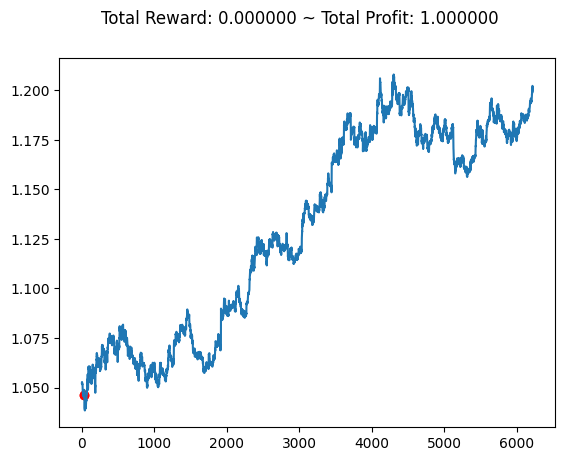

In [4]:
env.reset()
env.render()

- **Short** and **Long** positions are shown in `red` and `green` colors.
- As you see, the starting *position* of the environment is always **Short**.

### A complete example

info: {'total_reward': 27.89616584777832, 'total_profit': 0.989812615901, 'position': <Positions.Long: 1>}


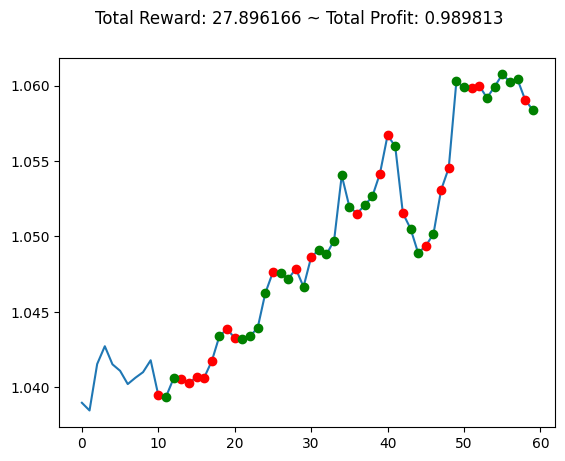

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL


env = gym.make('forex-v0', frame_bound=(50, 100), window_size=10)
# env = gym.make('stocks-v0', frame_bound=(50, 100), window_size=10)

observation = env.reset(seed=2023)
while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.unwrapped.render_all()
plt.show()

- You can use `render_all` method to avoid rendering on each step and prevent time-wasting.
- As you see, the first **10** points (`window_size`=10) on the plot don't have a *position*. Because they aren't involved in calculating reward, profit, etc. They just display the first observations. So the environment's `_start_tick` and initial `_last_trade_tick` are **10** and **9**.

### Extend and manipulate TradingEnv

Method 1

In [6]:
def my_process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Close', 'Open', 'High', 'Low']].to_numpy()[start:end]
    return prices, signal_features


class MyForexEnv(ForexEnv):
    _process_data = my_process_data


env = MyForexEnv(df=FOREX_EURUSD_1H_ASK, window_size=12, frame_bound=(12, len(FOREX_EURUSD_1H_ASK)))

Method 2:

In [7]:
def my_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size
    end = frame_bound[1]
    prices = df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = df.loc[:, ['Close', 'Open', 'High', 'Low']].to_numpy()[start:end]
    return prices, signal_features


class MyStocksEnv(StocksEnv):
    
    def __init__(self, prices, signal_features, **kwargs):
        self._prices = prices
        self._signal_features = signal_features
        super().__init__(**kwargs)

    def _process_data(self):
        return self._prices, self._signal_features

    
prices, signal_features = my_process_data(df=STOCKS_GOOGL, window_size=30, frame_bound=(30, len(STOCKS_GOOGL)))
env = MyStocksEnv(prices, signal_features, df=STOCKS_GOOGL, window_size=30, frame_bound=(30, len(STOCKS_GOOGL)))